In [8]:
# import pandas as pd
# from pathlib import Path

# # 定义常量
# START_TIME = 'start_time'
# END_TIME = 'end_time'
# ACTIVITY = 'activity'
# DEVICE = 'device'
# VALUE = 'value'

# def _fix_data(input_path, output_path):
#     """修正原始数据格式并生成清洗后的 CSV"""
#     with open(input_path, 'r') as f_o, open(output_path, 'w') as f_t:
#         for line in f_o:
#             s = line.strip().split()
#             if len(s) < 4:
#                 continue  # 忽略不完整的行
            
#             # 处理特殊标签
#             if s[2] in ['ENTERHOME', 'LEAVEHOME']:
#                 continue
#             if s[2] == 'c':
#                 s[2] = 'M014'
            
#             # 清理数值字段
#             value = s[3]
#             if 'c' in value:
#                 value = value.replace('c', '')
#             if s[2].startswith('M') and '5' in value:
#                 value = value.replace('5', '')
#             if value in ['ONM026', 'ONM009', 'ONM024']:
#                 value = 'ON'
#             if s[2].startswith('M') and len(value) == 1:
#                 value = 'ON'
#             if s[2].startswith('M') and len(value) == 2 and s[1] == '18:13:47.291404':
#                 value = 'OFF'
            
#             # 构建新行
#             new_line = f"{s[0]} {s[1]},{s[2]},{value}"
#             if len(s) >= 5:
#                 new_line += f",{' '.join(s[4:])}"
#             f_t.write(new_line + '\n')

# def _get_devices_df(df):
#     """处理设备数据"""
#     df = df.drop(ACTIVITY, axis=1).copy()
    
#     # 二进制设备 (ON/OFF)
#     binary_mask = (df[VALUE] == 'ON') | (df[VALUE] == 'OFF')
#     df_binary = df[binary_mask].copy()
#     df_binary[VALUE] = df_binary[VALUE] == 'ON'
    
#     # 数值型设备
#     numeric_mask = pd.to_numeric(df[VALUE], errors='coerce').notnull()
#     df_numeric = df[numeric_mask].copy()
#     df_numeric[VALUE] = df_numeric[VALUE].astype(float)
    
#     # 分类设备
#     df_cat = df[~binary_mask & ~numeric_mask].copy()
    
#     # 合并结果
#     df_final = pd.concat([df_binary, df_numeric, df_cat])
#     df_final.columns = [START_TIME, DEVICE, VALUE]
#     return df_final.sort_values(START_TIME).reset_index(drop=True)

# def _get_activity_df(df):
#     """处理活动数据，正确配对 Begin/End 事件"""
#     df_act = df[~df[ACTIVITY].isna()][[START_TIME, ACTIVITY]].copy()
#     print(df_act.head())
#     df_act[ACTIVITY] = df_act[ACTIVITY].str.strip()

#     result = []

#     # 1. 按活动名称分组（去除 " Begin" 或 " End" 后缀）
#     for activity_name in df_act[ACTIVITY].str.lower().str.replace(r' (begin|end)$', '', regex=True).unique(): # lower case is added
#         df_activity = df_act[df_act[ACTIVITY].str.lower().str.contains(activity_name.lower())].copy() # lower case is added

#         # 2. 分离 Begin 和 End 事件
#         df_begin = df_activity[df_activity[ACTIVITY].str.lower().str.endswith('begin')].copy() # lower case is added
#         df_end = df_activity[df_activity[ACTIVITY].str.lower().str.endswith('end')].copy() # lower case is added

#         # 3. 处理 Begin 或 End 缺失的情况
#         if not df_begin.empty and not df_end.empty:  # 确保 Begin 和 End 都存在
#             # 基于最早的 Begin 和最早的 End 进行合并
#             df_begin = df_begin.sort_values(START_TIME).reset_index(drop=True)
#             df_end = df_end.sort_values(START_TIME).reset_index(drop=True)

#             min_len = min(len(df_begin), len(df_end))  # 处理 Begin 和 End 条目数量不同的情况
#             df_begin = df_begin.iloc[:min_len]
#             df_end = df_end.iloc[:min_len]

#             df_begin[ACTIVITY] = activity_name
#             df_begin[END_TIME] = df_end[START_TIME].values
#             result.append(df_begin)
#         elif not df_begin.empty:  # 如果只有 Begin，则保留，但没有结束时间
#             df_begin[ACTIVITY] = activity_name
#             df_begin[END_TIME] = None  # 或者使用 pd.NaT 表示缺失时间
#             result.append(df_begin)
#         elif not df_end.empty:  # 如果只有 End，则保留，但没有开始时间
#             df_end[ACTIVITY] = activity_name
#             df_end[START_TIME] = None  # 或者使用 pd.NaT
#             result.append(df_end)

#     return pd.concat(result)[[START_TIME, END_TIME, ACTIVITY]].reset_index(drop=True)

# def _load_corrected_dfs(corrected_path):
#     """加载修正后的 CSV 并分离设备和活动数据"""
#     df = pd.read_csv(
#         corrected_path,
#         names=[START_TIME, DEVICE, VALUE, ACTIVITY],
#         parse_dates=[START_TIME]
#     ).sort_values(START_TIME).dropna(subset=[DEVICE, VALUE])
    
#     return _get_devices_df(df), _get_activity_df(df)

# def load(data_path):
#     """主加载函数：输入原始数据路径，返回处理后的数据集"""
#     origin_path = data_path / 'data'
#     corrected_path = data_path / 'corrected_data.csv'
#     _fix_data(origin_path, corrected_path)
    
#     df_dev, df_act = _load_corrected_dfs(corrected_path)

#     if data_path:
#         df_act.to_csv(data_path / 'activities.csv', index=False)
#         df_dev.to_csv(data_path / 'devices.csv', index=False)
    
#     return {
#         'activities': df_act,
#         'devices': df_dev,
#         'activity_list': df_act[ACTIVITY].unique().tolist(),
#         'device_list': df_dev[DEVICE].unique().tolist()
#     }

# if __name__ == '__main__':
#     dataset = load(Path('../dataset/casas/Aruba'))
#     print("Activities DataFrame:")
#     print(dataset['activities'].head())
#     print("\nDevices DataFrame:")
#     print(dataset['devices'].head())
#     print("\nActivity List:")
#     print(dataset['activity_list'])
#     print("\nDevice List:")
#     print(dataset['device_list'])

In [ ]:
import pandas as pd
from pathlib import Path

# 定义常量
START_TIME = 'start_time'
END_TIME = 'end_time'
ACTIVITY = 'activity'
DEVICE = 'device'
VALUE = 'value'

# 设备名称映射字典
DEVICE_MAPPING = {
    'M003': 'M003_Bedroom1_Bed',
    'T002': 'T002_Living_Corner',
    'T003': 'T003_Kitchen_Counter',
    'T004': 'T004_Aisle_near_Bathroom2',
    'T005': 'T005_Office_Desk',
    'T001': 'T001_Bedroom1_Nightstand',
    'M002': 'M002_Bedroom1_Closet',
    'M007': 'M007_Bedroom1_Bedside',
    'M005': 'M005_Bedroom1_Doorway',
    'M004': 'M004_Bathroom1_Doorway',
    'M006': 'M006_Aisle_near_Bedroom1',
    'M008': 'M008_Aisle_near_Bedroom1',
    'M020': 'M020_Living_Center',
    'M010': 'M010_Living_Corner',
    'M011': 'M011_Aisle_near_Bedroom1',
    'M012': 'M012_Living_TV_Area',
    'M013': 'M013_Living_Table',
    'M014': 'M014_Dining_Table',
    'M009': 'M009_Living_Corner',
    'M018': 'M018_Kitchen_Counter',
    'M019': 'M019_Kitchen_Stove',
    'M015': 'M015_Kitchen_Door',
    'M016': 'M016_Backdoor_Entrance',
    'M017': 'M017_Backdoor_Hallway',
    'M021': 'M021_Aisle_near_Bathroom2',
    'M022': 'M022_Aisle_near_Bathroom2',
    'M023': 'M023_Bedroom2_Doorway',
    'M001': 'M001_Bedroom1_Corner',
    'M024': 'M024_Bedroom2_Bedside',
    'D002': 'D002_Backdoor',
    'M031': 'M031_Bathroom2_Doorway',
    'D004': 'D004_Garage_Door',
    'M030': 'M030_Aisle_near_Bathroom2',
    'M029': 'M029_Aisle_near_Bathroom2',
    'M028': 'M028_Office_Desk',
    'D001': 'D001_Frontdoor',
    'M026': 'M026_Office_Corner',
    'M027': 'M027_Office_Chair',
    'M025': 'M025_Office_Bookshelf'
}

ACTIVITY_MAPPING = {
    'sleeping': 'sleep',
    'bed_to_toilet': 'bed_to_toilet',
    'meal_preparation': 'cook',
    'relax': 'relax',
    'housekeeping': 'chores',
    'eating': 'eat',
    'wash_dishes': 'chores',
    'leave_home': 'leave_home',
    'enter_home': 'enter_home',
    'work': 'work',
    'respirate': 'other'
}

def _fix_data(input_path, output_path):
    """修正原始数据格式并生成清洗后的 CSV"""
    with open(input_path, 'r') as f_o, open(output_path, 'w') as f_t:
        for line in f_o:
            s = line.strip().split()
            if len(s) < 4:
                continue  # 忽略不完整的行
            
            # 处理特殊标签
            if s[2] in ['ENTERHOME', 'LEAVEHOME']:
                continue
            if s[2] == 'c':
                s[2] = 'M014'
            
            # 应用设备名称映射
            device = s[2]
            if device in DEVICE_MAPPING:
                s[2] = DEVICE_MAPPING[device]
            
            # 清理数值字段
            value = s[3]
            if 'c' in value:
                value = value.replace('c', '')
            if s[2].startswith('M') and '5' in value:
                value = value.replace('5', '')
            if value in ['ONM026', 'ONM009', 'ONM024']:
                value = 'ON'
            if s[2].startswith('M') and len(value) == 1:
                value = 'ON'
            if s[2].startswith('M') and len(value) == 2 and s[1] == '18:13:47.291404':
                value = 'OFF'
            
            # 构建新行
            new_line = f"{s[0]} {s[1]},{s[2]},{value}"
            if len(s) >= 5:
                new_line += f",{' '.join(s[4:])}"
            f_t.write(new_line + '\n')

def _get_devices_df(df):
    """处理设备数据"""
    df = df.drop(ACTIVITY, axis=1).copy()
    
    # 二进制设备 (ON/OFF)
    binary_mask = (df[VALUE] == 'ON') | (df[VALUE] == 'OFF')
    df_binary = df[binary_mask].copy()
    df_binary[VALUE] = df_binary[VALUE] == 'ON'
    
    # 数值型设备
    numeric_mask = pd.to_numeric(df[VALUE], errors='coerce').notnull()
    df_numeric = df[numeric_mask].copy()
    df_numeric[VALUE] = df_numeric[VALUE].astype(float)

    # 删除温度超过200的数据
    temperature_sensors = ['T002_Living_Corner', 'T003_Kitchen_Counter', 'T004_Aisle_near_Bathroom2', 'T005_Office_Desk', 'T001_Bedroom1_Nightstand']
    temperature_mask = df_numeric[DEVICE].isin(temperature_sensors)
    df_numeric.loc[temperature_mask, VALUE] = df_numeric.loc[temperature_mask, VALUE].where(df_numeric.loc[temperature_mask, VALUE] <= 200)
    df_numeric = df_numeric.dropna(subset=[VALUE])
    
    # 分类设备
    df_cat = df[~binary_mask & ~numeric_mask].copy()
    
    # 合并结果
    df_final = pd.concat([df_binary, df_numeric, df_cat])
    df_final.columns = [START_TIME, DEVICE, VALUE]
    return df_final.sort_values(START_TIME).reset_index(drop=True)

def _get_activity_df(df):
    """处理活动数据，正确配对 Begin/End 事件"""
    df_act = df[~df[ACTIVITY].isna()][[START_TIME, ACTIVITY]].copy()
    df_act[ACTIVITY] = df_act[ACTIVITY].str.strip()

    result = []

    # 按活动名称分组
    for activity_name in df_act[ACTIVITY].str.lower().str.replace(r' (begin|end)$', '', regex=True).unique():
        df_activity = df_act[df_act[ACTIVITY].str.lower().str.contains(activity_name.lower())].copy()

        # 分离 Begin 和 End 事件
        df_begin = df_activity[df_activity[ACTIVITY].str.lower().str.endswith('begin')].copy()
        df_end = df_activity[df_activity[ACTIVITY].str.lower().str.endswith('end')].copy()

        # 处理 Begin 或 End 缺失的情况
        if not df_begin.empty and not df_end.empty:
            df_begin = df_begin.sort_values(START_TIME).reset_index(drop=True)
            df_end = df_end.sort_values(START_TIME).reset_index(drop=True)

            min_len = min(len(df_begin), len(df_end))
            df_begin = df_begin.iloc[:min_len]
            df_end = df_end.iloc[:min_len]

            df_begin[ACTIVITY] = activity_name
            df_begin[END_TIME] = df_end[START_TIME].values
            result.append(df_begin)
        elif not df_begin.empty:
            df_begin[ACTIVITY] = activity_name
            df_begin[END_TIME] = None
            result.append(df_begin)
        elif not df_end.empty:
            df_end[ACTIVITY] = activity_name
            df_end[START_TIME] = None
            result.append(df_end)

        df_final=pd.concat(result)[[START_TIME, END_TIME, ACTIVITY]].sort_values(START_TIME).reset_index(drop=True)
        df_final[ACTIVITY] = df_final[ACTIVITY].map(ACTIVITY_MAPPING)
    return df_final

def _load_corrected_dfs(corrected_path):
    """加载修正后的 CSV 并分离设备和活动数据"""
    df = pd.read_csv(
        corrected_path,
        names=[START_TIME, DEVICE, VALUE, ACTIVITY],
        parse_dates=[START_TIME]
    ).sort_values(START_TIME).dropna(subset=[DEVICE, VALUE])
    
    return _get_devices_df(df), _get_activity_df(df)

def load(data_path):
    """主加载函数：输入原始数据路径，返回处理后的数据集"""
    origin_path = data_path / 'data'
    corrected_path = data_path / 'corrected_data.csv'
    _fix_data(origin_path, corrected_path)
    
    df_dev, df_act = _load_corrected_dfs(corrected_path)

    if data_path:
        df_act.to_csv(data_path / 'activities.csv', index=False)
        df_dev.to_csv(data_path / 'devices.csv', index=False)
    
    return {
        'activities': df_act,
        'devices': df_dev,
        'activity_list': df_act[ACTIVITY].unique().tolist(),
        'device_list': df_dev[DEVICE].unique().tolist()
    }

if __name__ == '__main__':
    dataset = load(Path('../dataset/casas/Aruba'))
    print("Activities DataFrame:")
    print(dataset['activities'].head())
    print("\nDevices DataFrame:")
    print(dataset['devices'].head())
    print("\nActivity List:")
    print(dataset['activity_list'])
    print("\nDevice List:")
    print(dataset['device_list'])

Activities DataFrame:
                   start_time                    end_time       activity
0  2010-11-04 00:03:50.209589  2010-11-04 05:40:43.642664          sleep
1  2010-11-04 05:40:51.303739  2010-11-04 05:43:30.279021  bed_to_toilet
2    2010-11-04 05:43:45.7324   2010-11-04 08:01:12.28297          sleep
3  2010-11-04 08:11:09.966157  2010-11-04 08:27:02.801314           cook
4  2010-11-04 08:33:52.929406  2010-11-04 08:35:45.822482           cook

Devices DataFrame:
                   start_time                     device  value
0  2010-11-04 00:03:50.209589          M003_Bedroom1_Bed   True
1  2010-11-04 00:03:57.399391          M003_Bedroom1_Bed  False
2  2010-11-04 00:15:08.984841         T002_Living_Corner   21.5
3  2010-11-04 00:30:19.185547       T003_Kitchen_Counter   21.0
4  2010-11-04 00:30:19.385336  T004_Aisle_near_Bathroom2   21.0

Activity List:
['sleep', 'bed_to_toilet', 'cook', 'relax', 'chores', 'eat', 'leave_home', 'enter_home', 'work', 'other']

Device List:


Number of duplicated timestamps: 113


C:\Users\leave\AppData\Local\Temp\ipykernel_29272\2599355155.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_temp_hourly = df_temp.groupby('device')['value'].resample('1H').mean().reset_index()


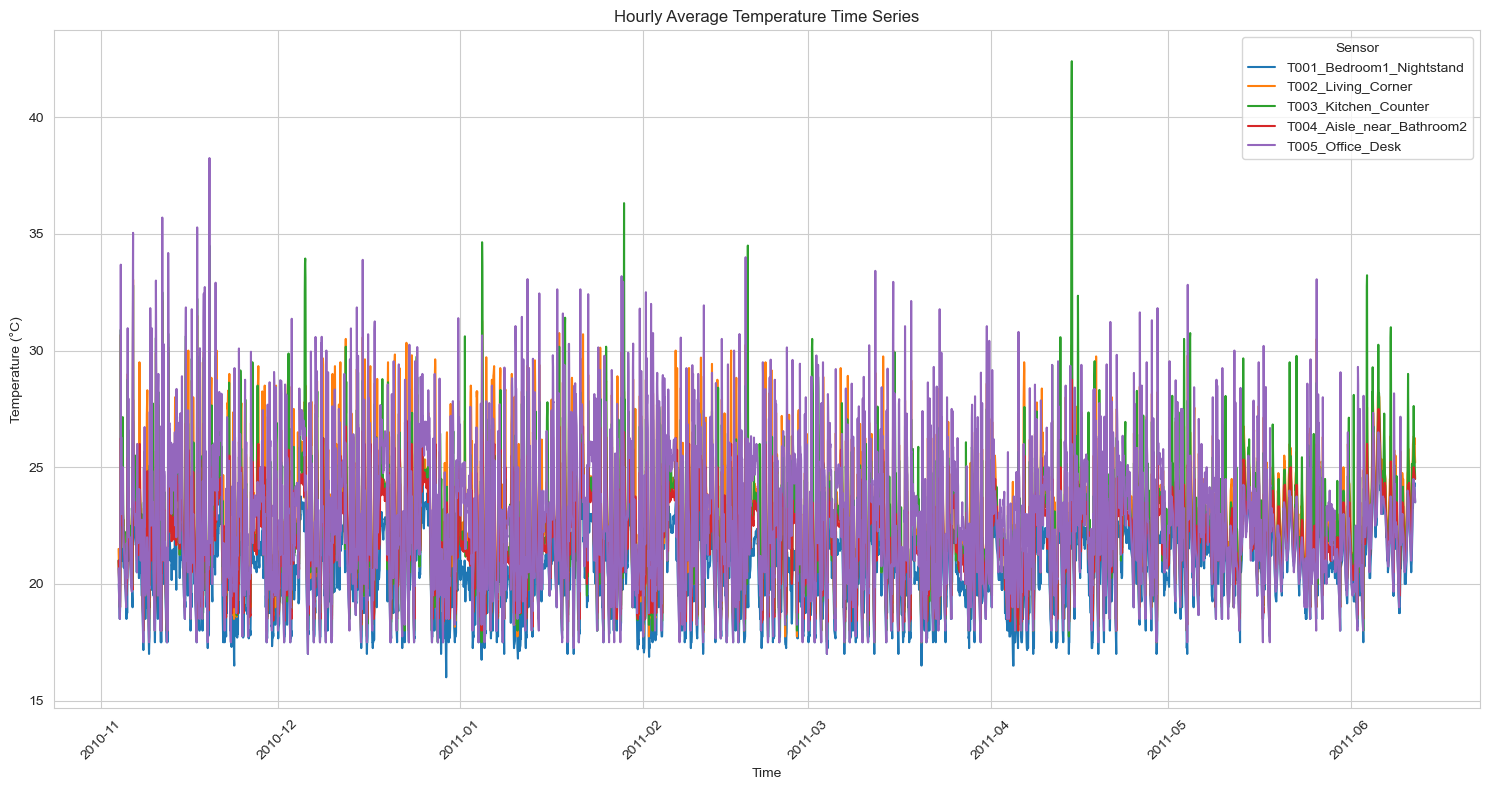

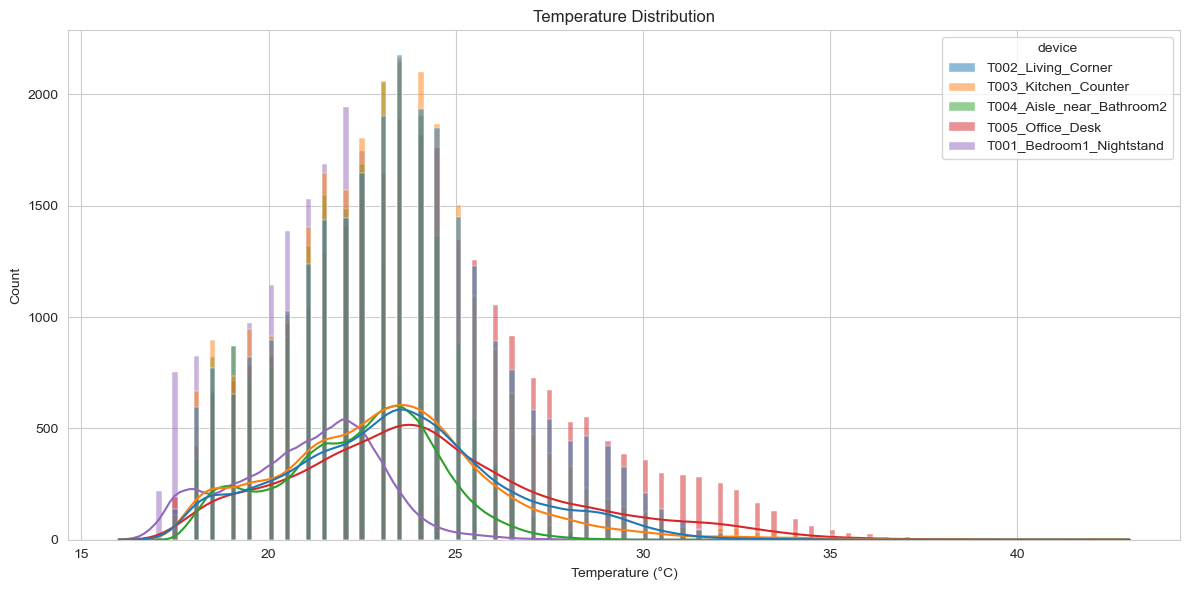

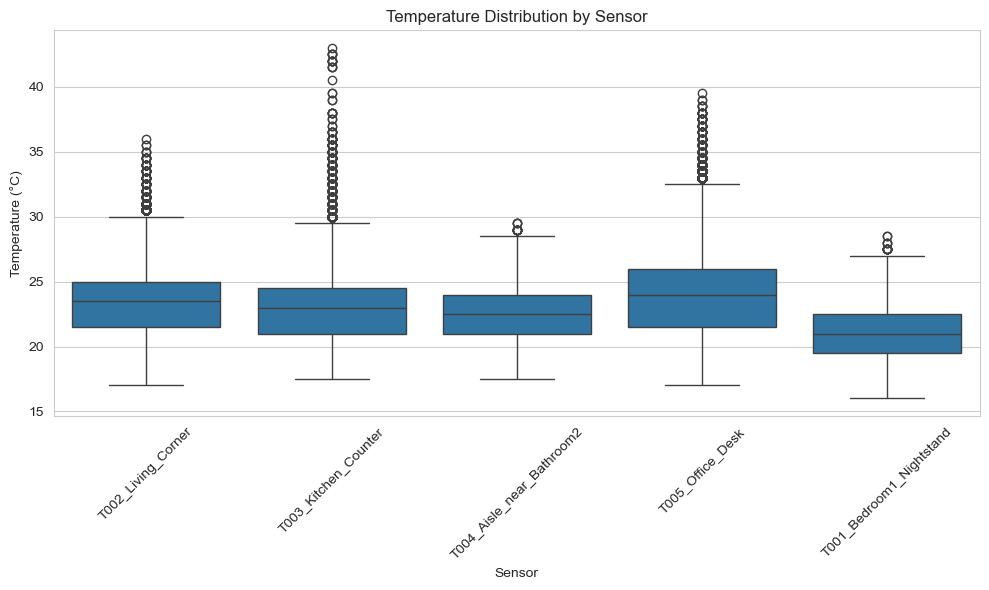


Descriptive Statistics by Sensor:
                             count   mean   std   min   25%   50%   75%   max
device                                                                       
T001_Bedroom1_Nightstand   16600.0  21.00  1.90  16.0  19.5  21.0  22.5  28.5
T002_Living_Corner         26222.0  23.42  2.92  17.0  21.5  23.5  25.0  36.0
T003_Kitchen_Counter       26417.0  23.15  2.92  17.5  21.0  23.0  24.5  43.0
T004_Aisle_near_Bathroom2  20193.0  22.38  2.07  17.5  21.0  22.5  24.0  29.5
T005_Office_Desk           27136.0  24.18  3.60  17.0  21.5  24.0  26.0  39.5


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 筛选温度传感器数据
temp_sensors = [
    'T002_Living_Corner', 
    'T003_Kitchen_Counter', 
    'T004_Aisle_near_Bathroom2', 
    'T005_Office_Desk', 
    'T001_Bedroom1_Nightstand'
]

# 正确筛选 'device' 列
df_temp = dataset['devices'][dataset['devices']['device'].isin(temp_sensors)].copy()

# 将温度值转换为数值类型，处理非数值
df_temp['value'] = pd.to_numeric(df_temp['value'], errors='coerce')

# 删除包含 NaN 或 NaT 的行
df_temp = df_temp.dropna(subset=['start_time', 'value'])

# 将 start_time 转换为 datetime 类型并设置为索引
df_temp['start_time'] = pd.to_datetime(df_temp['start_time'])
df_temp.set_index('start_time', inplace=True)

# 检查重复的时间戳
print(f"Number of duplicated timestamps: {df_temp.index.duplicated().sum()}")

# 按小时重采样（仅对数值数据进行操作）
df_temp_hourly = df_temp.groupby('device')['value'].resample('1H').mean().reset_index()

# 设置 Seaborn 样式
sns.set_style("whitegrid")

# 绘制时间序列图
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_temp_hourly, x='start_time', y='value', hue='device')
plt.title('Hourly Average Temperature Time Series')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend(title='Sensor')
plt.tight_layout()
plt.show()

# 绘制直方图
plt.figure(figsize=(12, 6))
sns.histplot(data=df_temp.reset_index(), x='value', hue='device', kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.tight_layout()
plt.show()

# 绘制箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_temp.reset_index(), x='device', y='value')
plt.title('Temperature Distribution by Sensor')
plt.xlabel('Sensor')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 计算描述性统计
stats = df_temp.groupby('device')['value'].describe()
print("\nDescriptive Statistics by Sensor:")
print(stats.round(2))

In [ ]:
# M003_Bedroom1_Bed
# T002_Living_Corner
# T003_Kitchen_Counter
# T004_Aisle_near_Bathroom2
# T005_Office_Desk
# T001_Bedroom1_Nightstand
# M002_Bedroom1_Closet
# M007_Bedroom1_Bedside
# M005_Bedroom1_Doorway
# M004_Bathroom1_Doorway
# M006_Aisle_near_Bedroom1
# M008_Aisle_near_Bedroom1
# M020_Living_Center
# M010_Living_Corner
# M011_Aisle_near_Bedroom1
# M012_Living_TV_Area
# M013_Living_Table
# M014_Dining_Table
# M009_Living_Corner
# M018_Kitchen_Counter
# M019_Kitchen_Stove
# M015_Kitchen_Door
# M016_Backdoor_Entrance
# M017_Backdoor_Hallway
# M021_Aisle_near_Bathroom2
# M022_Aisle_near_Bathroom2
# M023_Bedroom2_Doorway
# M001_Bedroom1_Corner
# M024_Bedroom2_Bedside
# D002_Backdoor
# M031_Bathroom2_Doorway
# D004_Garage_Door
# M030_Aisle_near_Bathroom2
# M029_Aisle_near_Bathroom2
# M028_Office_Desk
# D001_Frontdoor
# M026_Office_Corner
# M027_Office_Chair
# M025_Office_Bookshelf
